In [1]:
using DifferentialEquations
using Plots
using LinearAlgebra
using Statistics
using QuadGK
using ForwardDiff
using TaylorSeries
using Printf
using ProgressMeter
using Base.Threads


In [2]:
# Parameters
# Degree of taylor expansion
const Order = 5



5

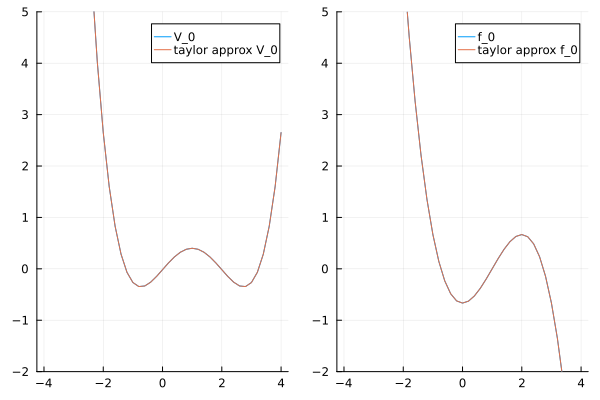

In [3]:
const shift_V_0 = 1
const V_0(x) = (x-shift_V_0)^4/12 - 1/2*(x-shift_V_0)^2 +2/10 * (shift_V_0-4) + 1

"""
Get the Taylor expansion and the dynamic functions
accordign to \$f(x) = -\\frac{\\partial V_0(x)}{\\partial x}\$

Argument:
    - V_0: the potential funciton
    - Order: the order of Taylor expansion at 0

Return:
    [f_0, tV_0, tf_0]:

Note:
    prefix t means Taylor expansions

"""
function getFunctions(V_0, Order)
    f_0(x) = -ForwardDiff.derivative(V_0, x)

    # Taylor expansion
    t = Taylor1(Float64, Order)
    tV_0 = V_0(t)
    tf_0 = -derivative(tV_0)
    
    return [f_0, tV_0, tf_0]
end

f_0, tV_0, tf_0 = getFunctions(V_0, Order)

# Plot the Taylor expansion to make sure it looks fine

x = -4:0.2:4
y1 = V_0.(x)
y2 = tV_0.(x)
y3 = f_0.(x)
y4 = tf_0.(x)

# p1 = plot(x, y1, ylims)

plot(x, y1, ylims=(-2, 5), label="V_0")
p1 = plot!(x, y2, ylims=(-2, 5), label="taylor approx V_0")
plot(x, y3, ylims=(-2, 5), label="f_0")
p2 = plot!(x, y4, ylims=(-2,5), label="taylor approx f_0")
plot(p1, p2, layout = (1, 2))

# Scalar function (m=1)

In [4]:
# Extended dimension
N = 2

"""
The embedding function
Argument:
    - X: value to evaluate (N, 1)
    - a: the Taylor coefficients of the function
    - commutative (default true): if the embedding function is commutative
Return:
    - The value of the embedding (N, 1)
"""
function CommF(X, a, commutative=true)
    
    N = length(X)
    M = length(a) - 1
    result = zeros(N, N)
    
    Ω₁ = fill(1, (N, N)) / N
    
    for i=0:M
        if commutative == 1
            result += a[i+1] * Ω₁ * diagm(X)^i
        else
            result += a[i+1] * (Ω₁ * diagm(X))^i
        end
    end
    return result * fill(1, (N, 1)) # b is set to be 1 here, but it can be more generalized
end

X = [1; 2]
const a = tf_0.coeffs
const M = length(a) - 1


display(CommF(X, a))
display(CommF(X, a, false))


2×1 Matrix{Float64}:
 0.33333333333333326
 0.33333333333333326

2×1 Matrix{Float64}:
 0.45833333333333326
 0.45833333333333326

$$
\frac{dX}{dt} = \sum_{i=0}^N \Omega_1 a_i X^i \vec{1} - \alpha (I - \Omega_1) \vec{1}
$$

In [5]:
#=
"""
The derivative function for the dynamics
Argument:
    - dX: the placeholder to receive output
    - X: the value to evaluate
    - p: the parameter list
        - p[1]: the α in the argument
        - p[2]: whether to use commutative embedding function
        - p[3]: the number of a (i.e. N in the formula)
        - p[4..]: the list of a
Return:
    Inplace output in dX

"""
function f!(dX, X, p, t=0)
    N = length(X)
    Ω₁ = fill(1, (N, N)) / N
    
    α = p[1] # First parameter for α
    comm = p[2] # Second parameter for commutative function
    len_a = Integer(p[3])
    a = @view p[4:4+len_a - 1]
    
    result = CommF(X, a, comm)
    result -= α * (I - Ω₁) * X

    dX .= result
    dX
end


function direct_f(X, p, t=0)
    N = length(X)
    dX = zeros(Float64, N)
    f!(dX, X, p, t)
end
=#

"""
Return the average gradient, given the gradient function
TODO: also the original function?
"""
function ExtendedF!(dX, X, f, alpha)
    N = length(X)
    Omega1 = fill(1, (N, N)) / N
    first_term = mean(f.(X))
    second_term = -alpha * (I - Omega1) * X
    
    if !isnothing(dX)
        dX .= first_term .+ second_term
    end
    first_term .+ second_term
end
function ExtendedF(X, f, alpha)
    ExtendedF!(nothing, X, f, alpha)
end

function GenerateF(f, alpha)
   (dX, X, p=0, t=0) -> ExtendedF!(dX, X, f, alpha)
end


dX = [0., 0.]

# p = vcat([1, true, length(a)], a)


# println(f!(dX, [1, 2], p))
println(dX)
# println(direct_f([1, 2], p))

println(ExtendedF([1,2], f_0, 1))
println(GenerateF(f_0, 1)(nothing, [1,2]))

[0.0, 0.0]
[0.8333333333333334, -0.16666666666666663]
[0.8333333333333334, -0.16666666666666663]


## One dynamic

2.732047594384305


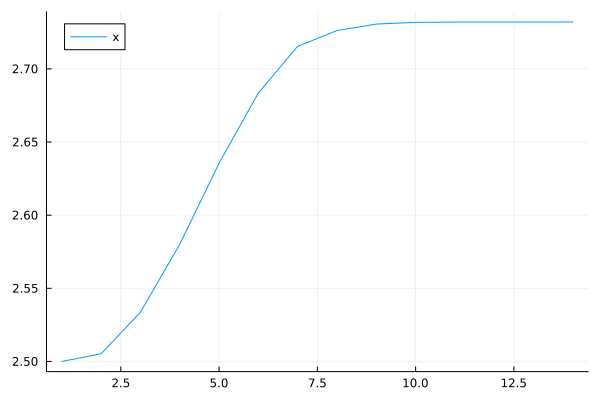

In [6]:
#="""
Get the solution of the ODE problem defined by f!
Argument:
    - X₀: the initial value
    - tspan: the time range for the problem
    - p: the parameter to pass in the problem
Return:
    - The solution

"""
function getSolution(X₀, f, tspan, p; ts=0.1, verbose=true)
    prob = ODEProblem(f!, X₀, tspan, p)
    sol = solve(prob, saveat=ts, verbose=verbose)
    return sol
end

sol = getSolution(X₀, tspan, p, verbose=false)

=#

X₀ = [3; 2]
tspan = (0, 10)

grad_f = GenerateF(f_0, 1)

prob = ODEProblem(grad_f, [3; 2], tspan, 0)
sol = solve(prob)


x = [mean(vec) for vec in sol.u]

println(x[end])
plot(x, label="x")



### Slope field

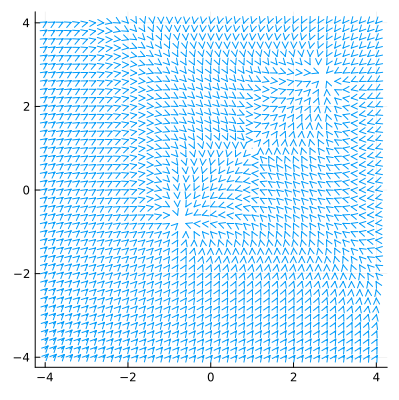

In [7]:
meshgrid(x, y) = (repeat(x, outer=length(y)), repeat(y, inner=length(x)))
x, y = meshgrid(-4:0.2:4, -4:0.2:4)

u = zeros(Float64, length(x))
v = zeros(Float64, length(y))

tmp = map((xi, yi) -> grad_f(nothing, [xi; yi]), x, y)

u = [i[1] for i in tmp]
v = [i[2] for i in tmp]

scale = 0.002
u .= scale * u
v .= scale * v
quiver(x, y, quiver=(u, v))
slope_field = plot!(size=(400,400))

### Initial points

Probability of global convergence: 74.50%


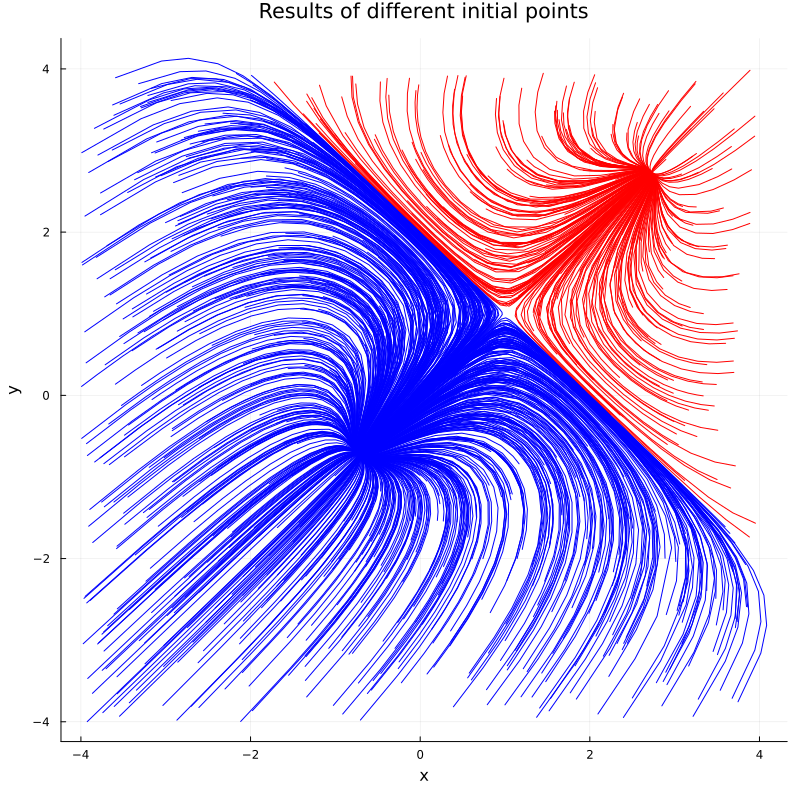

In [8]:
plot()

x, y = meshgrid(-4:0.1:4, -4:0.1:4)
grid = [[a, b] for (a, b) in zip(x, y)]

global_count, local_count = 0, 0

for i in 1:1000
    X0 =  -4. .+ 8. .* rand(2)
    
    prob = ODEProblem(grad_f, X0, tspan)
    sol = solve(prob)
    # sol = getSolution(X0, (0, 10), p)
    
    global global_count, local_count

    # Extract x and y values
    x_values = [point[1] for point in sol.u]
    y_values = [point[2] for point in sol.u]

    # Create scatter plot
    if y_values[end] < 0
        color = :blue
        global_count += 1
    else
        color = :red
        local_count += 1
    end
    
    plot!(x_values, y_values, title="Results of different initial points", 
        xlabel="x", ylabel="y", legend=false, linecolor = color)
end

@printf("Probability of global convergence: %.2f%%\n", global_count / (global_count + local_count) * 100)
# println()

plot!(size=(800,800))


## Two particles dynamics

In [9]:
X0 = [4;-1.5]
prob = ODEProblem(grad_f, X0, tspan)
sol = solve(prob)
# sol = getSolution(X0, (0, 10), p)
x1 = [i[1] for i in sol.u]
x2 = [i[2] for i in sol.u]

y1 = V_0.(x1)
y2 = V_0.(x2)
println()
# plot(slope_field)
# scatter!(x1, x2, label='X')

[ Info: Saved animation to /Users/charliechen/workspace/am_sure/dynamic.gif


Plots.AnimatedGif("/Users/charliechen/workspace/am_sure/dynamic.gif")
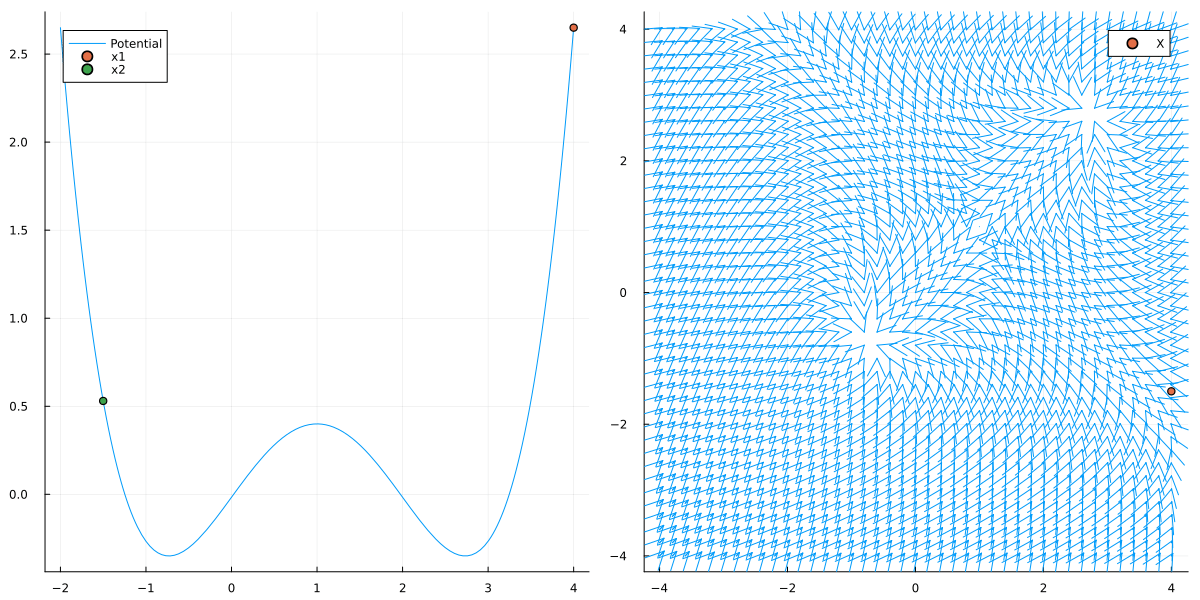

In [10]:
anim = @animate for i in eachindex(x1)
    plot(V_0, -2, 4, label = "Potential")
    scatter!([x1[i]], [y1[i]], label = "x1")
    p1 = scatter!([x2[i]], [y2[i]], label = "x2")
    
    plot(slope_field)
    p2 = scatter!([x1[i]], [x2[i]], label="X")
    
    plot(p1, p2, layout=(1,2), size = (1200, 600))
end fps = 2
gif(anim, "dynamic.gif", fps=2)

In [11]:
direct_f([x1[11], x2[11]], p)

LoadError: UndefVarError: `direct_f` not defined

[ Info: Saved animation to /Users/charliechen/workspace/am_sure/potential.gif


Plots.AnimatedGif("/Users/charliechen/workspace/am_sure/potential.gif")
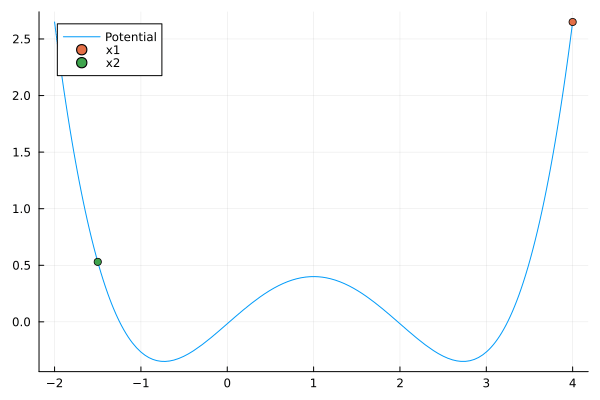

In [12]:
anim = @animate for i in eachindex(x1)
    plot(V_0, -2, 4, label = "Potential")
    scatter!([x1[i]], [y1[i]], label = "x1")
    scatter!([x2[i]], [y2[i]], label = "x2")
end fps = 2
gif(anim, "potential.gif", fps=2)

## N particle dynamics

In [23]:
V_0(x) = x^8 - 8x^6 + 19x^4 - 12x^2 + 2
f_0 = x -> -ForwardDiff.derivative(V_0, x)
grad_f = GenerateF(f_0, 1)

#=
f_0, tV_0, tf_0 = getFunctions(V_0, 8)
p = vcat([1, true, length(tf_0.coeffs)], tf_0.coeffs)
=#

#4 (generic function with 3 methods)

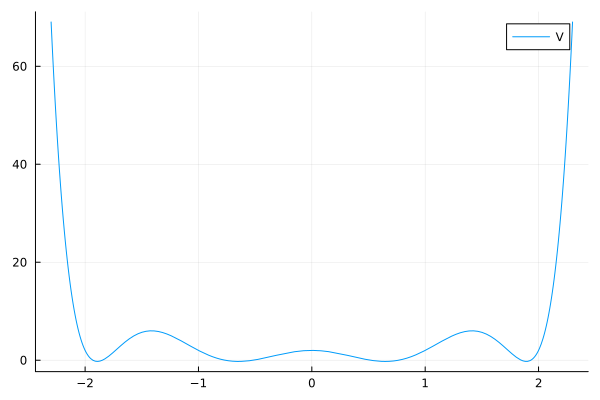

In [24]:
plot(V_0, -2.3, 2.3, label="V")

In [25]:
N = 10
Ω₁ = fill(1, (N, N)) / N

# X0 = [4;-1.5; 1.2; 1.3]
X0 = (rand(N) .- 0.5) .* 2 .* 2
# X0 = [2.006145848242574, -1.2094066791560183, 2.412284620250457, 1.9682204891942996]

prob = ODEProblem(grad_f, X0, tspan)
sol = solve(prob)

# sol = getSolution(X0, (0, 10), p)

println(X0)

[1.0731755546570838, 1.3408492479336478, 0.8055806300736421, 0.6082396166615927, 1.8644970857756595, -1.027976325384083, 1.7594124164385168, 0.26110072175926735, 1.1150942446055154, -0.2078997144980086]


Converge to 0.65

[ Info: Saved animation to /Users/charliechen/workspace/am_sure/dynamic.gif


Plots.AnimatedGif("/Users/charliechen/workspace/am_sure/dynamic.gif")
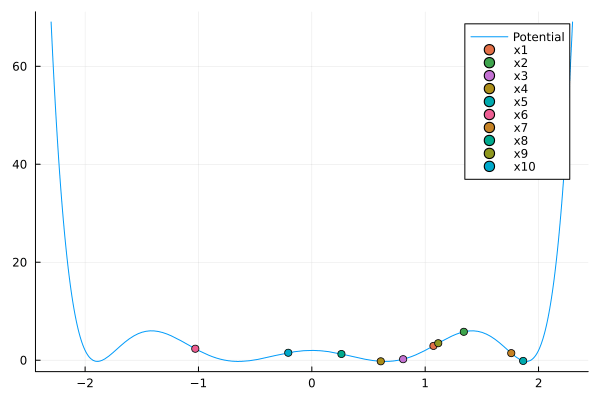

In [26]:
anim = @animate for i in eachindex(sol.u)
    lower = min(minimum(sol.u[i]) - 0.5, -2.3)
    upper = max(maximum(sol.u[i]) + 0.5, 2.3)
    lower, upper = -2.3, 2.3

    plot(V_0, lower, upper, label = "Potential")
    for j in eachindex(sol.u[1])
        x = sol.u[i][j]
        y = V_0(x)
        scatter!([x], [y], label = "x$j")
    end
    # scatter!([x1[i]], [y1[i]], label = "x1")
    # scatter!([x2[i]], [y2[i]], label = "x2")
    # scatter!([x3[i]], [y3[i]], label = "x3")
end fps = 30

@printf("Converge to %.2f", mean(sol.u[end]))

gif(anim, "dynamic.gif")

## Experiments for different N

In [27]:
struct GridStruct
    lower::Float64
    upper::Float64
    grid_size::Float64
    dimension::Int64
end

In [28]:
function Base.iterate(g::GridStruct)
    res = fill(g.lower, g.dimension)
    state = fill(1, g.dimension)
    
    return res, state
end

function Base.iterate(g::GridStruct, state::Vector{Int64})
    one_grid = collect(g.lower:g.grid_size:g.upper)
    max_index = length(one_grid)
    
    index = length(state)
    
    while index > 0
        state[index] += 1
        if state[index] > max_index
            if index > 1
                reset = state[index-1] + 1
                for j in index:length(state)
                    state[j] = reset
                end
                # state[index] = state[index - 1] + 1
            end
            index -= 1
        else
            res = zeros(g.dimension)
            # println(state)
            # println(one_grid)
            for i in eachindex(res)
                res[i] = one_grid[state[i]]
            end
            return res, state
        end
    end
    
    return nothing
end

function Base.length(g::GridStruct)
    count = 0
    for x in g
        count += 1
    end
    count
end
    
grid = GridStruct(-2, 2, 0.2, 2)
length(grid)

231

In [29]:

function grid_experiment(N, X_list_iterator, optimum, tol=0.1)        
    # Create a progress bar
    progress_bar = Progress(length(X_list_iterator), false)
    
    count = Atomic{Int64}(0)
    @threads for X0 in X_list_iterator
        
        # println(X0)
        
        prob = ODEProblem(grad_f, X0, tspan)
        sol = solve(prob, Rosenbrock23(), verbose=true)
        
        if abs(mean(sol.u[end]) - optimum) < tol
            atomic_add!(count,1)
        end
        next!(progress_bar)
    end
    return count[] / length(X_list_iterator)
end

grid_experiment (generic function with 2 methods)

In [30]:
N_results = Float64[]

for N=1:3
    X_list_iterator = collect(GridStruct(-2, 2, 0.2, N))
    println("The total number of sample: ", length(X_list_iterator))
    push!(N_results, grid_experiment(N, X_list_iterator, -1.89))
    println("N_results: ", N_results)
    flush(stdout)
end

The total number of sample: 21


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


N_results: [0.14285714285714285]


Progress:  65%|██████████████████████████▌              |  ETA: 0:00:00

The total number of sample: 231


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


N_results: [0.14285714285714285, 0.24675324675324675]


Progress:   8%|███▎                                     |  ETA: 0:00:01

The total number of sample: 1771


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00                                                                Progress:  79%|████████████████████████████████▌        |  ETA: 0:00:00


N_results: [0.14285714285714285, 0.24675324675324675, 0.1880293619424054]


## Plotting

For the potential function
$$
V(x) = x^8 - 8x^6 + 19x^4 - 12x^2 + 2x + 2
$$

The results (ran on HPC) are 
| Number of Particles (N) | Global Convergence Probability | Grid Size |
|------------------------|-------------------------------|-----------|
| 1                      | 0.19047619047619047          | 0.2       |
| 2                      | 0.30385487528344673          | 0.2       |
| 3                      | 0.3911024727351258           | 0.2       |
| 4                      | 0.3213990055583836           | 0.2       |
| 5                      | 0.35958795661001797          | 0.4       |
| 6                      | 0.3716778120713306           | 0.8       |



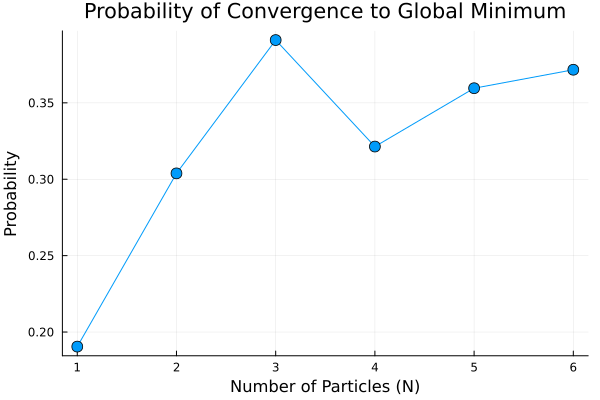

In [21]:
# Define the number of particles and corresponding convergence probabilities
num_particles = [1, 2, 3, 4, 5, 6]
convergence_probabilities = [0.19047619047619047, 0.30385487528344673, 0.3911024727351258,
                             0.3213990055583836, 0.35958795661001797, 0.3716778120713306]

# Create the plot
plot(num_particles, convergence_probabilities, marker = :circle, markersize = 6,
     xlabel = "Number of Particles (N)", ylabel = "Probability",
     title = "Probability of Convergence to Global Minimum",
     legend = false)